In [ ]:
"""
Modified create_data_set notebook. It includes more classes, relevant for sidewalk problem, and combines similar classes (eg. van, car, truck, trailer into one class).
Output: sidewalk_v2 directory in GTA5_dataset directory. 
"""

In [25]:
import os
import random
import glob
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
def get_image_names(sequence, start_image, end_image):

    image_names = []
    for image_idx in range(start_image, end_image + 1, 10):
        image_str = str(image_idx)
        while(len(image_str) < 5):
            image_str = '0' + image_str
        
        image_str += '.png'
        image_names.append(os.path.join(sequence, sequence + '_' + image_str))
    return image_names

In [ ]:
def get_image_full_path(data_root, image_name, image_set, image_type):
    return os.path.join(data_root, image_set, image_type, image_name)

In [ ]:
def resize_image(img_path, width, height, save_path=None):
    resized_img = Image.open(img_path)
    resized_img = resized_img.resize((width, height))
    
    if save_path is not None:
        resized_img.save(save_path)

    return resized_img

In [ ]:
def category_to_id(category):
    category_dict = {
        'unlabeled' : 0,
        'ambiguous' : 1,
        'sky'       : 2,
        'road'      : 3,
        'sidewalk'  : 4,
        'railtrack' : 5,
        'terrain'   : 6,
        'tree'      : 7,
        'vegetation': 8,
        'building'  : 9,
        'infrastructure' : 10,
        'fence'          : 11,
        'billboard'      : 12,
        'trafficlight'   : 13,
        'trafficsign'    : 14,
        'mobilebarrier'  : 15,
        'firehydrant'    : 16,
        'chair'          : 17,
        'trash'          : 18,
        'trashcan'       : 19,
        'person'         : 20,
        'animal'         : 21,
        'bicycle'        : 22,
        'motorcycle'     : 23,
        'car'            : 24,
        'van'            : 25,
        'bus'            : 26,
        'truck'          : 27,
        'trailer'        : 28,
        'train'          : 29,
        'plane'          : 30,
        'boat'           : 31
    }
    return category_dict[category]

In [ ]:
def create_label_image(label_image_path, categories, resize=None, save_path=None):
    """
    Combined classes: 
        veg: {'tree' : 7, 'vegetation' : 8}
        vehicles: {'car' : 24, 'van' : 25, 'bus' : 26, 'truck' : 27, 'trailer' : 28}
        bikes: {'bicycle' : 22, 'motorcycle' : 23}

    Final classes:
        1 sidewalk
        2 road
        3 veg
        4 building
        5 fence
        6 trafficsign
        7 firehydrant
        8 person
        9 bikes
        10 vehicles

    """
    same_category = ['tree', 'bicycle', 'car', 'van', 'bus', 'truck']

    if resize is not None:
        new_width = resize[0]
        new_height = resize[1]
        cls_image = np.array(resize_image(label_image_path, new_width, new_height, save_path=None))
    else:
        cls_image = np.array(Image.open(label_image_path))
    
    result_image = np.zeros(cls_image.shape, dtype=np.uint8)

    class_count = 1
    for category in categories:
        category_id = category_to_id(category)
        result_image += np.array(cls_image == category_id, dtype=np.uint8) * class_count
        #print(category, class_count)

        if category not in same_category:
            class_count += 1
        

    out_image = Image.fromarray(result_image, 'L')
    
    if save_path is not None:
        out_image.save(save_path)
    
    return out_image
        

In [ ]:
image_names  = get_image_names('075', 1170, 3200)
image_names += get_image_names('072', 10, 1590)
image_names += get_image_names('071', 10, 2660)
image_names += get_image_names('069', 10, 2410)
image_names += get_image_names('068', 1290, 4790)
image_names += get_image_names('066', 200, 2270)
image_names += get_image_names('065', 10, 560)
image_names += get_image_names('062', 1860, 2640)
image_names += get_image_names('050', 220, 2760)
image_names += get_image_names('049', 610, 3840)
image_names += get_image_names('049', 4550, 4970)
image_names += get_image_names('043', 1000, 2820)

# print(image_names)

data_root = './GTA5_dataset'
processed_data_root = os.path.join(data_root, 'sidewalk_data_v2')
processed_data_train_rgb = os.path.join(processed_data_root, 'train', 'rgb')
processed_data_train_label = os.path.join(processed_data_root, 'train', 'label')

if not os.path.exists(processed_data_train_rgb):
    os.makedirs(processed_data_train_rgb)
if not os.path.exists(processed_data_train_label):
    os.makedirs(processed_data_train_label)

NEW_IMAGE_HEIGHT = 338
NEW_IMAGE_WIDTH  = 600
CATEGORIES = ['sidewalk', 'road', 'tree', 'vegetation', 'building', 'fence',  'trafficsign', 'firehydrant', 'person', 'bicycle', 'motorcycle', 'car', 'van', 'bus', 'truck', 'trailer']

merged_categories = ['sidewalk', 'road', 'veg', 'building', 'fence',  'trafficsign', 'firehydrant', 'person', 'bikes', 'vehicles']
pixel_counts = {0 : 0, 'n_image_0' : 0}
for c, category in enumerate(merged_categories, 1):
    cat_pix_count = {c: 0, 
                     'n_image_' + str(c) : 0}
    pixel_counts.update(cat_pix_count)

print(pixel_counts)

with open(os.path.join(processed_data_root, 'train.txt'), 'w') as file:
    for idx, image_name in enumerate(image_names):
        raw_rgb_image_path = get_image_full_path(data_root, image_name, image_set='train', image_type='img')
        raw_label_image_path = get_image_full_path(data_root, image_name, image_set='train', image_type='cls')

        output_rgb_path = os.path.join(processed_data_train_rgb, image_name)
        output_label_path = os.path.join(processed_data_train_label, image_name)

        new_image = resize_image(raw_rgb_image_path, NEW_IMAGE_WIDTH, NEW_IMAGE_HEIGHT, save_path=output_rgb_path)
        label_image = create_label_image(raw_label_image_path, CATEGORIES, resize=(NEW_IMAGE_WIDTH, NEW_IMAGE_HEIGHT), save_path=output_label_path)

        pair = '{} {}\n'.format(output_rgb_path, output_label_path)
        file.write(pair)

        values, counts = np.unique(label_image, return_counts = True)
        for value, count in zip(values, counts):
            pixel_counts[value] += count
            if (count > 0):
                pixel_counts['n_image_' + str(value)] += 1

        if idx % 100 == 0:
            print('Processing', image_name)
            print(pixel_counts)

In [ ]:
print(pixel_counts)
class_pixel_freqs = [pixel_counts[i] for i in range(int(len(pixel_counts) / 2))]
print('class pixel freq', class_pixel_freqs)
class_pixel_freqs = sorted(class_pixel_freqs)
print('Sorted class pixel freq', class_pixel_freqs)

freq_median = np.median(class_pixel_freqs)
print('Pixel median', freq_median)

In [ ]:
def class_freq(n_pixel, n_image_presented, image_shape):
    total_pixel = n_image_presented * image_shape[0] * image_shape[1]
    return n_pixel / total_pixel

In [ ]:
classes_alpha = [class_freq(pixel_counts[i], pixel_counts['n_image_' + str(i)], (NEW_IMAGE_HEIGHT, NEW_IMAGE_WIDTH)) for i in range(int(len(pixel_counts) / 2))]
print(classes_alpha)

In [ ]:
weights = [0.23975128696351541, 0.2507147462990658, 0.16095488789992088, 0.07417991627042077, 0.2352810984060984, 0.012232230619511656, 0.0018319206780745242, 0.0007349405147719907, 0.017041525215062206, 0.0009230732839872778, 0.027867874511862293]
weights = [len(weights)*wi for wi in weights]
print(weights)

In [ ]:
20 * 2369


Creating Val Dataset

In [ ]:
def get_image_names(sequence, start_image, end_image):
    image_names = []
    for image_idx in range(start_image, end_image + 1, 10):
        image_str = str(image_idx)
        while(len(image_str) < 5):
            image_str = '0' + image_str
            
        image_str += '.png'
        image_names.append(os.path.join(sequence, sequence + '_' + image_str))
    return image_names

In [ ]:
image_names  = get_image_names('047', 10, 1390)
image_names += get_image_names('044', 10, 1400)
image_names += get_image_names('043', 10, 4810)
image_names += get_image_names('042', 10, 170)
image_names += get_image_names('040', 10, 1800)

# print(image_names)

data_root = './GTA5_dataset'
processed_data_root = os.path.join(data_root, 'sidewalk_data_v2')
processed_data_val_rgb = os.path.join(processed_data_root, 'val', 'rgb')
processed_data_val_label = os.path.join(processed_data_root, 'val', 'label')

if not os.path.exists(processed_data_val_rgb):
    os.makedirs(processed_data_val_rgb)
if not os.path.exists(processed_data_val_label):
    os.makedirs(processed_data_val_label)

NEW_IMAGE_HEIGHT = 338
NEW_IMAGE_WIDTH  = 600
CATEGORIES = ['sidewalk', 'road', 'tree', 'vegetation', 'building', 'fence',  'trafficsign', 'firehydrant', 'person', 'bicycle', 'motorcycle', 'car', 'van', 'bus', 'truck', 'trailer']

merged_categories = ['sidewalk', 'road', 'veg', 'building', 'fence',  'trafficsign', 'firehydrant', 'person', 'bikes', 'vehicles']
pixel_counts = {0 : 0, 'n_image_0' : 0}
for c, category in enumerate(merged_categories, 1):
    cat_pix_count = {c: 0, 
                     'n_image_' + str(c) : 0}
    pixel_counts.update(cat_pix_count)

print(pixel_counts)

with open(os.path.join(processed_data_root, 'val.txt'), 'w') as file:
    for idx, image_name in enumerate(image_names):
        raw_rgb_image_path = get_image_full_path(data_root, image_name, image_set='val', image_type='img')
        raw_label_image_path = get_image_full_path(data_root, image_name, image_set='val', image_type='cls')

        output_rgb_path = os.path.join(processed_data_val_rgb, image_name)
        output_label_path = os.path.join(processed_data_val_label, image_name)
        
        new_image = resize_image(raw_rgb_image_path, NEW_IMAGE_WIDTH, NEW_IMAGE_HEIGHT, save_path=output_rgb_path)
        label_image = create_label_image(raw_label_image_path, CATEGORIES, resize=(NEW_IMAGE_WIDTH, NEW_IMAGE_HEIGHT), save_path=output_label_path)

        pair = '{} {}\n'.format(output_rgb_path, output_label_path)
        file.write(pair)

        values, counts = np.unique(label_image, return_counts = True)
        for value, count in zip(values, counts):
            pixel_counts[value] += count
            if (count > 0):
                pixel_counts['n_image_' + str(value)] += 1

        if idx % 100 == 0:
            print('Processing', image_name)
            print(pixel_counts)

In [ ]:
data_root = './GTA5_dataset'
processed_data_root = os.path.join(data_root, 'sidewalk_data_v2')
processed_data_train_rgb = os.path.join(processed_data_root, 'train', 'rgb')
processed_data_train_label = os.path.join(processed_data_root, 'train', 'label')
print(processed_data_train_rgb)

In [28]:
image = Image.open('GTA5_dataset/sidewalk_data_v2/train/rgb/075/075_03080.png')

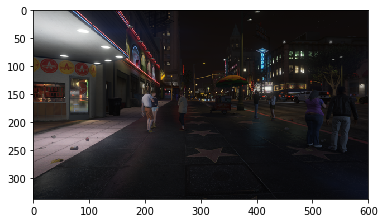

In [29]:
plt.imshow(image)